 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
persistence: 1841.156 RMSE (+/- 0.000)


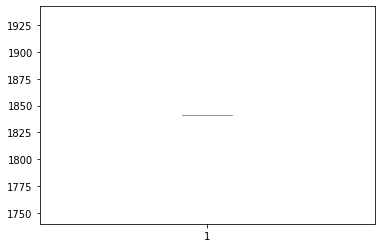

In [2]:
# 01_simple_forecast.py
# persistence forecast for monthly car sales dataset
from math import sqrt
from numpy import median
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
	return None

# forecast with a pre-fit model
def model_predict(model, history, config):
	values = list()
	for offset in config:
		values.append(history[-offset])
	return median(values)

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [12, 24, 36]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('persistence', scores)

 > 1391.470
 > 1739.703
 > 1458.272
 > 1684.817
 > 1649.623
 > 1543.025
 > 1354.524
 > 1431.304
 > 1580.333
 > 1500.955
 > 1667.848
 > 1462.627
 > 1761.133
 > 1452.723
 > 1518.190
 > 1445.364
 > 1658.637
 > 1572.653
 > 1589.558
 > 1482.228
 > 1546.780
 > 1499.838
 > 1759.339
 > 1688.784
 > 1637.769
 > 1642.978
 > 1727.425
 > 1397.332
 > 1595.090
 > 1465.508
mlp: 1563.528 RMSE (+/- 115.431)


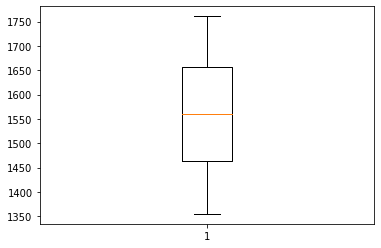

In [3]:
# 02_mlp_forecast_model.py
# evaluate mlp for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# prepare data
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape(1, n_input)
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [24, 500, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('mlp', scores)

 > 1457.611
 > 1625.640
 > 1614.196
 > 1661.381
 > 1614.485
 > 1524.083
 > 1567.696
 > 1594.321
 > 1600.039
 > 1739.662
 > 1589.917
 > 1549.660
 > 1619.382
 > 1480.755
 > 1449.596
 > 1528.716
 > 1499.695
 > 1585.005
 > 1519.713
 > 1598.655
 > 1514.042
 > 1564.069
 > 1644.660
 > 1506.497
 > 1538.989
 > 1681.977
 > 1598.115
 > 1521.546
 > 1719.758
 > 1495.996
cnn: 1573.529 RMSE (+/- 71.479)


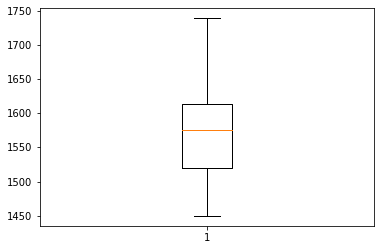

In [4]:
# 03_grid_search_monthly_shampoo_sales.py
# evaluate cnn  for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_filters, n_kernel, n_epochs, n_batch = config
	# prepare data
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(n_input, 1)))
	model.add(Conv1D(n_filters, n_kernel, activation='relu'))
	model.add(MaxPooling1D())
	model.add(Flatten())
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, _ = config
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 256, 3, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn', scores)

 > 2065.702
 > 2006.311
 > 1907.787
 > 2141.264
 > 2077.365
 > 4578.039
 > 2028.623
 > 2091.122
 > 2124.458
 > 2165.093
 > 2165.584
 > 2137.948
 > 2146.794
 > 2195.081
 > 2162.810
 > 2057.901
 > 2055.329
 > 1952.794
 > 2037.693
 > 2338.610
 > 2343.466
 > 2062.764
 > 2190.958
 > 2136.977
 > 2133.714
 > 2229.471
 > 2195.016
 > 2156.913
 > 2088.390
 > 2139.695
lstm: 2203.789 RMSE (+/- 450.407)


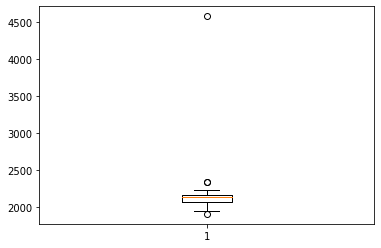

In [5]:
# 04_lstm_forecast_model.py
# evaluate lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 50, 100, 100, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('lstm', scores)

 > 1784.324
 > 1314.857
 > 2473.962
 > 1431.309
 > 1823.595
 > 1529.924
 > 1606.844
 > 1534.930
 > 1627.128
 > 1949.539
 > 1645.627
 > 1922.817
 > 1684.100
 > 1738.014
 > 1687.280
 > 1739.403
 > 1893.544
 > 1725.229
 > 1650.589
 > 1658.651
 > 1801.452
 > 1608.732
 > 1504.085
 > 1759.197
 > 1573.772
 > 1627.860
 > 1584.018
 > 1745.965
 > 1510.699
 > 1445.181
cnn-lstm: 1686.088 RMSE (+/- 205.329)


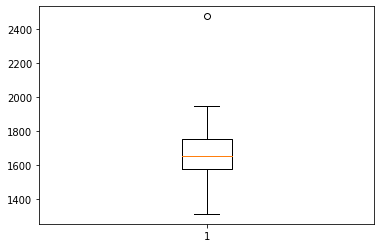

In [6]:
# 05_cnn_lstm_forecast_model.py
# evaluate cnn-lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
	n_input = n_seq * n_steps
	# prepare data
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
	# define model
	model = Sequential()
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(None,n_steps,1))))
	model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
	model.add(TimeDistributed(MaxPooling1D()))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 64, 3, 100, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

 > 1334.275
 > 1428.977
 > 1913.864
 > 1525.057
 > 1815.534
 > 1652.531
 > 1501.399
 > 1788.927
 > 1447.425
 > 1912.437
 > 1831.741
 > 2514.199
 > 1897.440
 > 1693.652
 > 1395.011
 > 1847.876
 > 1760.611
 > 1481.209
 > 1578.667
 > 1886.627
 > 1769.734
 > 1740.419
 > 1431.676
 > 1770.944
 > 1787.379
 > 2088.635
 > 1813.437
 > 1273.733
 > 2233.571
 > 1667.140
convlstm: 1726.138 RMSE (+/- 264.118)


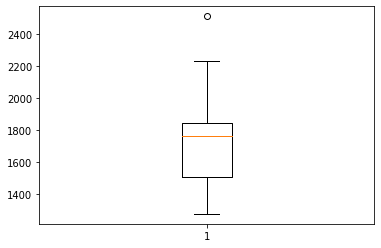

In [7]:
# 06_convlstm_forecast_model.py
# evaluate convlstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
	n_input = n_seq * n_steps
	# prepare data
	data = series_to_supervised(train, n_input)
	train_x, train_y = data[:, :-1], data[:, -1]
	train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(n_filters, (1,n_kernel), activation='relu', input_shape=(n_seq, 1, n_steps, 1)))
	model.add(Flatten())
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with a pre-fit model
def model_predict(model, history, config):
	# unpack config
	n_seq, n_steps, _, _, _, _, _ = config
	n_input = n_seq * n_steps
	# prepare data
	x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	return scores

# summarize model performance
def summarize_scores(name, scores):
	# print a summary
	scores_m, score_std = mean(scores), std(scores)
	print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
	# box and whisker plot
	pyplot.boxplot(scores)
	pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 256, 3, 200, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('convlstm', scores)